<a href="https://colab.research.google.com/github/Mahi200728/DataScience-A2/blob/main/Javi_MaheU5proj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
import xarray as xr
import pymc as pm
from scipy.interpolate import PchipInterpolator

# Unit 5 Project

I used the berry data set from you bank of data sets! I think the relationship between the sugar and chewiness is particularly interesting as you typically would expect sweeter berries to be chewier. To test whether that is true I created a linear model and a generalized linear model.



---



In [2]:
url_berry = 'https://raw.githubusercontent.com/thedarredondo/data-science-fundamentals/refs/heads/main/Data/berry_sugar_chewy.csv'
#I could have put the url string directly into pd.read_csv()
berry = pd.read_csv(url_berry)

In [3]:
berry

,nacl,sugar,chewiness
0,130,176.5,2.1381
1,130,176.5,3.6588
2,130,176.5,4.7656
3,130,176.5,1.1835
4,130,176.5,3.7518
...,...,...,...
85,180,258.5,1.7064
86,180,258.5,1.2969
87,180,258.5,1.0169
88,180,258.5,0.4185


I made a scatter plot of sugar versus chewiness for the berry data set. I chose sugar to be on the x axis because I believe that it would be the deciding factor on whether the berry ended up chewy or not.

<Axes: xlabel='sugar', ylabel='chewiness'>

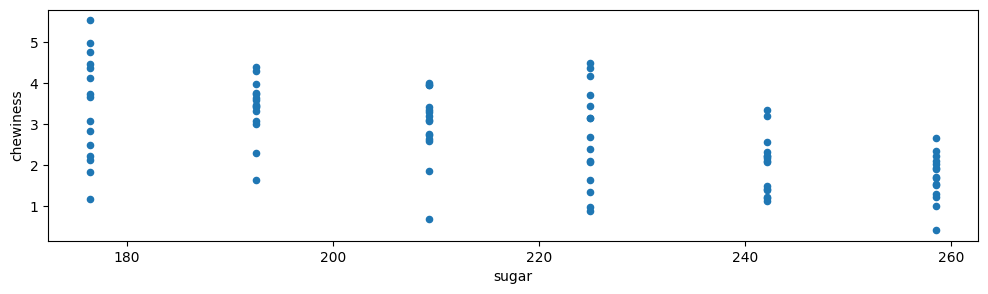

In [4]:
#scatter plot of Height v. Weight count of the howell data set
berry.plot(x="sugar", y="chewiness", figsize=(12, 3), kind="scatter")

I ran a straight line linear regression model on the berry data set with sugar predicting chewiness.

In [5]:
#li stands for linear iris
with pm.Model() as model_lb:

    #priors for the linear part of our model
    α = pm.Normal("α", mu=0, sigma=100)
    β = pm.Normal("β", mu=0, sigma=10)

    #this is the linear part of our model
    μ = pm.Deterministic("μ", α + β * berry.sugar)

    #prior for the standard deviation of our likelihood
    #Cauchy is a T dist with nu = 1
    σ = pm.HalfCauchy("σ", 10)

    #likelihood
    y_pred = pm.Normal("y_pred", mu=μ, sigma=σ, observed=berry.chewiness)

    #inference data object
    idata_lb = pm.sample()

Output()

Output()

Text(0, 0.5, 'chewiness')

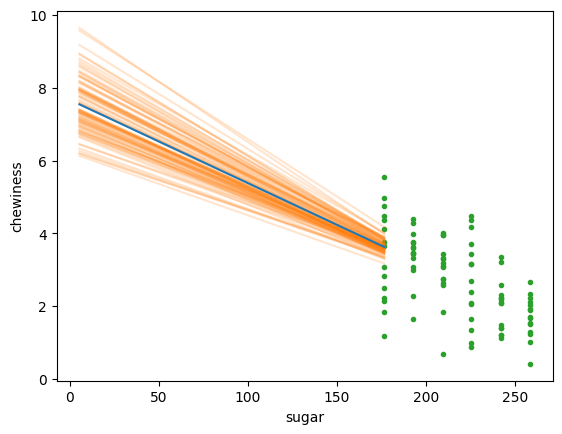

In [6]:
#grabs 100 posterior samples
posterior = az.extract(idata_lb, num_samples=90)

# grabbing x values for graphing.
x_plot = xr.DataArray(
    np.linspace(berry.sugar.min(), berry.chewiness.max(), 50),
    dims="plot_id"
    )

# this creates the expected line, the path we predict sugar and chewiness deviates from
mean_line = posterior["α"].mean() + posterior["β"].mean() * x_plot

#These are a 50 lines that our model came up with
lines = posterior["α"] + posterior["β"] * x_plot

#set up plot
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(berry.sugar, berry.chewiness, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("sugar")
ax.set_ylabel("chewiness")

This obviously doesn't look correct as all of the lines the model came up with were all before the first data points. This overall just didn't look correct.

In [7]:
pm.sample_posterior_predictive(idata_lb, model=model_lb,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

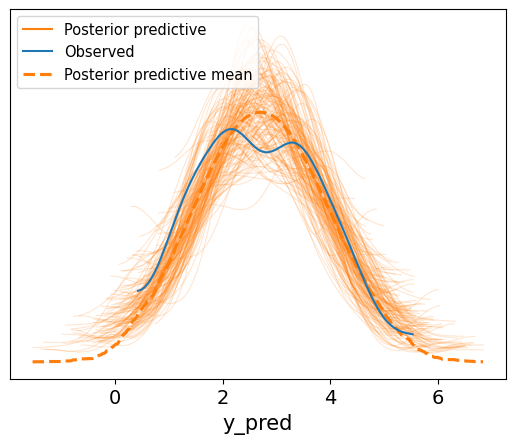

In [8]:
az.plot_ppc(idata_lb, num_pp_samples=150, colors=["C1", "C0", "C1"])

The fit of the posterior predictive check seemed correct when looking at the width but it doesn't make sense in regards to the peak where there is a dip around 3 on the y_pred axis.

I created a generalized linear model to fix the issues prsented before. I used gamma because to begin we know that the chewiness is going to be positive and continuous as it wouldn't make sense for a berry to be negatively chewy. Gamma also is able to handle skewness which is apparent in my graph as the first sugar data points have an overall higher chewiness score compared to more sugary berries. Gamma is also very adaptable and because my data was essentially catagoized into columns (something I am not very familiar with) I wanted to make sure my model was flexible enough for me to tweak around. Also in context to GLM we can see how the linear predictor connects with the chewiness.

In [9]:
with pm.Model() as model_glm_berry:
    # Priors for the intercept and slope
    α = pm.Normal("α", mu=0, sigma=10)  # Prior for intercept
    β = pm.Normal("β", mu=0, sigma=10)  # Prior for slope

    # Shape parameter for the Gamma distribution
    shape = pm.HalfNormal("shape", sigma=10) # Must be positive

    # Linear predictor (log link: exponentiate the linear model)
    μ = pm.math.exp(α + β * berry['sugar'])

    # Likelihood: Gamma distribution, use mu and shape (equivalent to alpha)
    # Since mu = alpha/beta, then beta = alpha/mu (I googled a lot)
    beta = shape / μ # Calculate beta from shape (alpha) and mu
    y_pred = pm.Gamma("y_pred", alpha=shape, beta=beta, observed=berry.chewiness)

    # Inference: Sample from the posterior
    idata_glm_berry = pm.sample()

Output()

Output()

In [10]:
pm.sample_posterior_predictive(idata_glm_berry, model=model_glm_berry,  extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

Text(0, 0.5, 'chewiness')

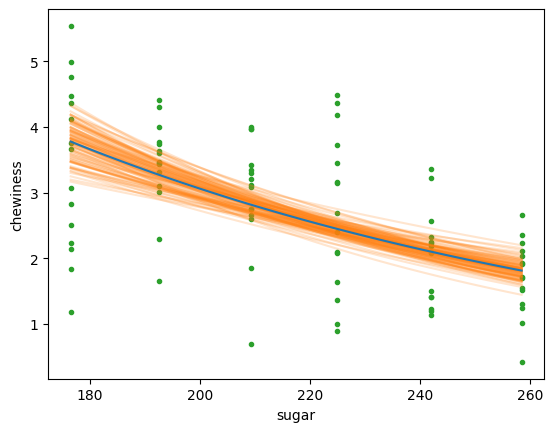

In [11]:
# Extract 90 posterior samples
posterior = az.extract(idata_glm_berry, num_samples=100)

# Generate x values for plotting
x_plot = xr.DataArray(
    np.linspace(berry.sugar.min(), berry.sugar.max(), 50),
    dims="plot_id"
)

# Compute mean line and sample lines (log link requires exp transformation)
mean_line = np.exp(posterior["α"].mean() + posterior["β"].mean() * x_plot)
lines = np.exp(posterior["α"] + posterior["β"] * x_plot)

# Plot results
_, ax = plt.subplots()

#plots 50 other lines our model came up with.
ax.plot(x_plot, lines.T, c="C1", alpha=0.2, label="lines")

#plots the mean line
ax.plot(x_plot, mean_line, c="C0", label="mean line")

#plot the raw data
ax.plot(berry.sugar, berry.chewiness, "C2.", zorder=-3)

#label axes and create legend
ax.set_xlabel("sugar")
ax.set_ylabel("chewiness")

As we can see based on the graph our relationship between chewiness and sugar is negative and linear. Now even though the data points don't actually look linear (are in columns) we can assume that the sugar levels are subjected to fluxation rather than only being at 195, 210, 225, etc. I think the issue that happened was that when gathering this data the researcher just approximated rather than going with the actual number which is what led to the data being very column like.

Text(0, 0.5, 'chewiness')

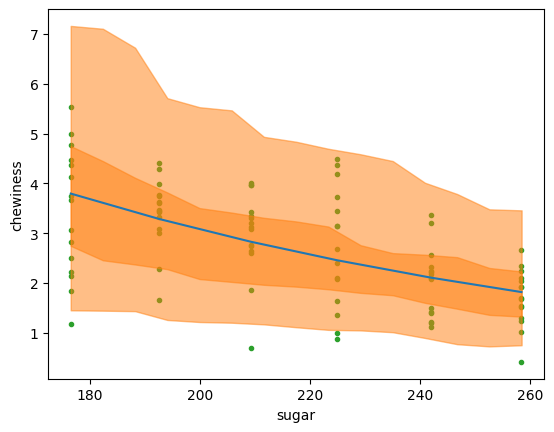

In [12]:
#plots the posterior predictive distribution

# We need to calculate the mean line using the parameters α and β
mean_line = np.exp(idata_glm_berry.posterior["α"].mean(("chain", "draw")).values + idata_glm_berry.posterior["β"].mean(("chain", "draw")).values * berry.sugar.values)

#creates some x values to run through our line formula
sugar = np.random.normal(berry.sugar.values, 0.01)
idx = np.argsort(sugar)
x = np.linspace(sugar.min(), sugar.max(), 15)

#grabs the 94% HDI and 50% HDI, and sets them up for graphing.
y_pred_q = idata_glm_berry.posterior_predictive["y_pred"].quantile(
    [0.03, 0.97, 0.25, 0.75], dim=["chain", "draw"]
)
y_hat_bounds = iter(
    [
        PchipInterpolator(sugar[idx], y_pred_q[i][idx])(x)
        for i in range(4)
    ]
)

#plots raw data and our line of best fit
_, ax = plt.subplots()
ax.plot(berry.sugar, berry.chewiness, "C2.", zorder=-3)
ax.plot(berry.sugar[idx], mean_line[idx], c="C0")


#graphs the 94% and 50% HDIs
for lb, ub in zip(y_hat_bounds, y_hat_bounds):
    ax.fill_between(x, lb, ub, color="C1", alpha=0.5)

#labels
ax.set_xlabel("sugar")
ax.set_ylabel("chewiness")

To fit what I said before I decided to plot the HDI values as well to help use get a better understand on how the data may have actually laid out if the sugar values weren't approximated. Based on this graph we can see the mean values for each sugar level and we can see where the chewiness is most likely to reside depending on the chewiness compared to where it would be least likely to reside. This is alos allows us to better understand our outliers (which was difficult because of the way the data is laid out). Based on this graph we can tell that a chweiness of ~1.2 at 175 sugar isn't condusive to the rest of the data, thus must be a high leverage data point.

Finally I ran a posterior predictive check, and visualize the posterior predictive distribution, for the gamma model I made.

In [13]:
pm.sample_posterior_predictive(idata_glm_berry, model=model_glm_berry, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='y_pred'>

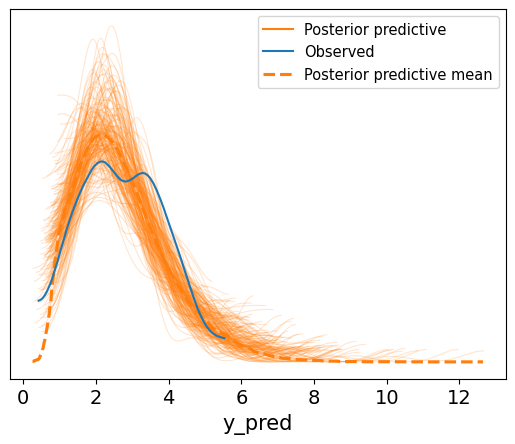

In [14]:
az.plot_ppc(idata_glm_berry, num_pp_samples=200, colors=["C1", "C0", "C1"])

Based on this posterior predictive distribution we can better visualized the skewiness of the data and the negative slope we identified earlier. This still doesn't fix the bump we see at the peak bit I think that has more to do with the data we were given rather than the actual models we created. I think overall this shows that we created a decent GLM fit for the data we were given.

## Conclusion
At the beginning of the project I hypothesized that the data would have a positive, linear correlation because I believed that the sweeter the berry is the more chewy it would be. But after creating these models and visualizing the data we can see that the opposite is true where the sweeter the berry the less chewy it is, hence the negative linear correlation. Also despite the data not actually appearing linear I still believe my earlier chracterizations hold true.